## Mounting your google drive on Colab Noetebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## reemplazá 'workshopml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/workshopml/ML_workshop2020/  
datapath = './data/clinvarHC_modeling.csv.gz'
targetname = 'ClinvarHC'

/content/drive/My Drive/workshopml/ML_workshop2020


## Importo paquetes

In [3]:
%matplotlib inline

# data manipulation
import pandas as pd
import numpy as np
from operator import itemgetter


## learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

## preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


### model performance
from sklearn import metrics

#ploting modules
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

## Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from IPython.display import Image
import src.utility_functions as uf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load and split data

In [4]:
SEED = 2718281
data = pd.read_csv(datapath,sep = ',',index_col='ChrPosRefAlt',nrows=500)
#X,y = data.drop([targetname],axis = 1), data[[targetname]]
X,y = data.drop([targetname],axis = 1), data[[targetname]]
## train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=SEED,stratify = y)


## Preprocessing

In [5]:
categorical_feature_mask = X_train.dtypes==object       # esto nos da un vector booleano 
categorical_columns = X_train.columns[categorical_feature_mask].tolist()  # acá picnhamos los nombres de esas columnas
numerical_columns = X_train.columns[~X_train.columns.isin(categorical_columns)] # defino las numéricas como el complemento de las categóricas 


numerical_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))])  # Esto es una vacancia de Sklearn, no permite aún "centrar" matrizes sparse


categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])      

preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer,numerical_columns),
    ('cat', categorical_transformer,categorical_columns)
])


## Vamos a explorar: 

* Optimización de hyperparámetros : gridsearch

* Convencernos que L1 mata features correlacionados y L2 distribuye los pesos


* Nro features (y cuáles) en términos de C (hyperparámetro de regularización). 




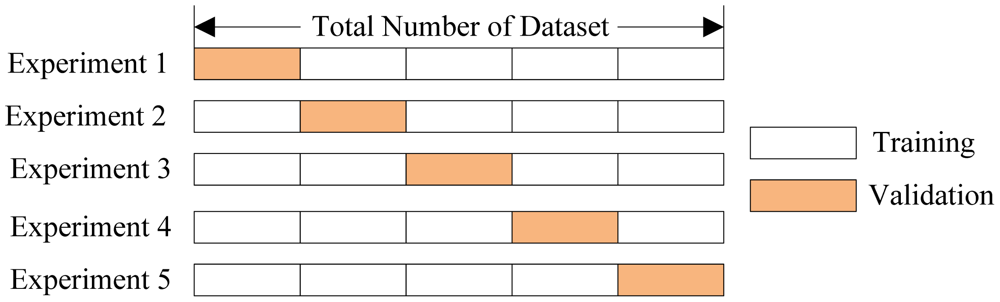

In [6]:
Image(filename = "./images/CrossValid.png", width=600, height=400)

## Definimos el modelo (incluido el preprocesamiento)

In [7]:
### Construimos el Pipeline
## Regresion Logistica 
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(solver = 'liblinear',max_iter=1000))])  
#especificamos el solver para evitar warnings


In [8]:
lr_C =  [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,100,1000]

## defino los hyperparámetros que voy a recorrer
param_grid = [
  {'clasificador__C':lr_C, 'clasificador__penalty': ['l1']}
]

search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, y_train[targetname].ravel())


bestpipe = search.best_estimator_  ## Nuestro pipeline se usó localmente. Con esta línea le paso la configuración óptima de la búsqueda


* GridSearchCV No retiene explícitamente los modelos generados (i.e. , sus coeficientes) en cada combinación de parámetros de la grilla de búsqueda. 


* Sólo retiene los scores de cada modelo generado, y los parámetros del modelo de "mejor performance", el que maximiza el scoring medio en el evaluation set)





### Cómo le va en performance?

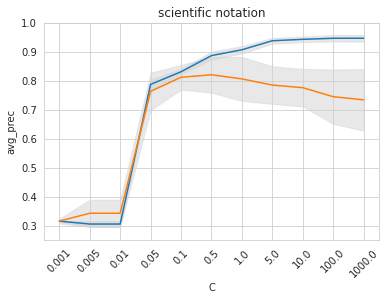

In [9]:
uf.my_train_test_plot(gridsearch= search,grid = param_grid,hyp = 'C',ylim = [0.25,1],ylabel = 'avg_prec') 
# notar:
# esta función la hice yo. La encuentran en /src/utililty_functions.py
# Básicamente toma el objeto search, la grilla con que fue generdo y un hyperparámetro de interés (que tiene que estar en la grilla)

# para cada valor de ese hiperparámetro te extrae la info de cómo le fue al modelo en el set de entrenamiento y en el de evaluación.
# luego, plote y lo hace mostrando las bandas de incertidumbre.

## Notar que: 
* Fijensé que para valores de C ariba de 1, la performance en el training y en el evaluation set , se empiezan a separar (los intervalos de confianza dejan de superponerse). Osea, sobreajuste seguro. 

* Las medias empiezan a abrirse en 0.1
* No obstante, nuestro máximo está en 0.5. Tomamos ese? 0.1? Las diferencias en performance son significativas? 
* Permítanme retomar esta pregunta bastante más adelante




******************************

Veamos explícitamente el C óptimo seleccionado por gridsearch (mira el evaluation, así que debería ser C = 0.5)


In [10]:
search.best_estimator_['clasificador']


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

###########################################################################
## Qué implicancia tiene en el modelo si lo vemos en términos de selección de variables?
###########################################################################

* Entreno modelos para cada valor de C (sin CV, usando todo el train) y retengo cada modelo. Notar que hasta ahora sólo tengo el modelo óptimo del CV.
Esto nos va a permitir analizar los coeficientes de cada modelo, en 
particular cuantas variable 'mató' (tiró a cero).


In [11]:
survival_featyres_l1_LR = {}  # aca voy a guardar la info de cuantos features no mató la regularización
model = {}                    # acá voy a guardar los modelos
for c in lr_C:
    pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(C=c,solver = 'liblinear',penalty='l1'))])
    Id = '%s'%c
    res = pipeline.fit(X_train,y_train[targetname].ravel())
    model.update({Id:res})

    surv = np.mean(model[Id]['clasificador'].coef_ != 0) * 100
    survival_featyres_l1_LR.update({Id: surv})

survival_features = pd.Series(survival_featyres_l1_LR)

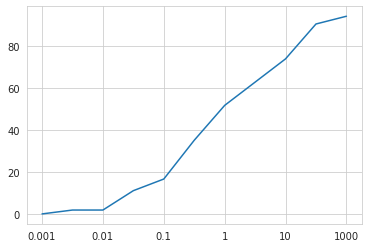

In [12]:
survival_features.plot()  #pandas es bello 


In [13]:
survival_features

0.001     0.000000
0.005     1.851852
0.01      1.851852
0.05     11.111111
0.1      16.666667
0.5      35.185185
1        51.851852
5        62.962963
10       74.074074
100      90.740741
1000     94.444444
dtype: float64

* ***Entre 0.1 y  1*** , la cantidad de features ***triplica***!!

(menos del 17% a más del 51%)


## Veamos ahora cuáles son los features que sobrevivieron y su importancia relativa
-- Nos vamos a parar en el valor de C "óptimo" del modelo --

In [14]:
## Primero recupero nombre de vairables del modelo entrenado. 

numerical_names = bestpipe.named_steps['preprocessing'].transformers[0][2].tolist()
categorical_output_names = bestpipe.named_steps['preprocessing'].named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()

cols = numerical_names + categorical_output_names  

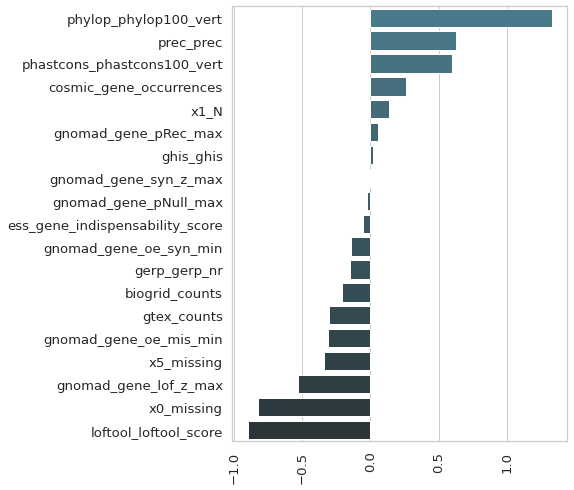

In [15]:
matplotlib.rcParams['figure.figsize'] = [6,8]
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
coefs = pd.Series(model['0.5']['clasificador'].coef_[0])

coefs.index = cols
coefs = coefs.sort_values(ascending=False)

# filtro los features que no fueron eliminados por L1
ii = abs(coefs)>0
g = sns.barplot(coefs[ii],coefs.index[ii], palette =sns.diverging_palette(220, 20, n=50, center = "dark"))
plt.xticks(rotation=90)
plt.show()

Sólo para recordar

* x0 : Interpro Domain
* x1 : Essenciality
* x5 : cnv flag (exac)

## No me parece menor la observacion de que, sobrevivieron features de distinta naturaleza: 
*  Conservación (phylop, phascons)
*  inferencia de loss of function (gnomad lof_z, loftool,)
*  Expresión en tejidos (gtex_counts)
*  Interpro domains (X0_missing). Osea, que la variante caiga fuera de un dominio estructural es informativo
*  Biogrid (ppi networks)

# Cuál es la performance del modelo?

In [16]:
cc = ['mean_test_score','std_test_score']
res = pd.DataFrame(itemgetter(*cc)(search.cv_results_),index = cc).transpose()
res['C']= lr_C
res [res.C==0.5]

,mean_test_score,std_test_score,C
5,0.820783,0.061806,0.5


In [17]:
## ahora la evaluación cruda y dura en el testing set (este no tiene intervalo de confianza)
ypred_test = model['0.5'].predict_proba(X_test)[:,1]
print('Average Precision %.3f'%metrics.average_precision_score(y_test,ypred_test))
# y vemos que, no sólo cayó dentro del intervalo sino que bastante cerca de la media!

Average Precision 0.815


### Notar que la performance en el test cayó dentro de nuestro rango obtenido en la validación cruzada


## Cuál es el valor de AUC ROC que obtenemos en el testing set?


In [18]:
print('AUC ROC %.3f'%metrics.roc_auc_score(y_test,ypred_test))

AUC ROC 0.889


## Bonus para el hogar

 
* Para calcular la significancia estadística entre las diferencias de AUC ROC halladas en C = 0.1 y C = 0.5. Osea, quiero saber si vale la pena incrementar el número de features, de un 18% a un 

 Nada mejor que el paquete pROC de R para esas cosas (tiene varias implementaciones para comparar AUCs). 
* si descomentan y corren van a estar llamando a R desde acá (python). Es medio chino pero en ocaciones amerita. Lo dejo para los que no lo conzcan, porque si en otra ocación necesitan unir lo mejor de esos dos mundos en un mismo notebook
* Las fierencias en el test en C = 0.5 o C = 0.1 no son significativas

In [19]:
#import rpy2 as r2p
#import rpy2.robjects as ro
#from rpy2.robjects.packages import importr
#import rpy2.robjects.numpy2ri
#rpy2.robjects.numpy2ri.activate()


#ro.r('''
#install.packages('pROC')
#library('pROC')
#roctest<- function(y,pred1,pred2){
#  rroc1 = roc(y,pred1)
#  rroc2 = roc(y,pred2)
#  signif <- pROC::roc.test(rroc1,rroc2)
#  return(signif)
#}
#''')
#pROC = importr('pROC')

#roctest = ro.globalenv['roctest']


#m05 = model['0.5'].predict_proba(X_train)
#m01 = model['0.1'].predict_proba(X_train)

#signif = roctest(y_train[targetname].values,m01[:,1],m05[:,1])
#pv = signif.rx('p.value')[0]
#print(pv)


## Hay diferencias significatias en los resultados obtenidos con C= 0.1 y C = 0.5 ? 

#* Hay algo mal acá... estoy viendo las diferencias del en el mismo lugar que entreno, osea equivale a ver las diferencias en la curva azul, no en la narajna.
# Tiene formato de código

### En el testing también da significativo (un poco menos, tiene sentido)
## Qué está mal de hacerlo así? 
## Cómo es la forma correcta?


#t01 = model['0.1'].predict_proba(X_test)
#t1 = model['0.5'].predict_proba(X_test)
#signif = roctest(y_test[targetname].values,t01[:,1],t1[:,1])
#pv = signif.rx('p.value')[0]
#print(pv)


